NRES Signal to  trend analysis
---

Plot normalized signal to noise as repoprted by NRES pipeline.

Input: a number of input files containing the signal to noise for starts:

   Format:
   STAR_NAME  Vmag  SN   Texp
       
Code will calculate the S/N normalized to a 60 sec exposure. However, this calculation assumes that 
exposurs remain shot noise dominated in this process, i.e., this calculation is somewhat off. 



In [7]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import glob
import tarfile
import tempfile
import os
import PyPDF2
import re
import shutil

from astroquery.simbad import Simbad
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [8]:

def readdata (fname):
    
    data = np.genfromtxt (fname, unpack=True, dtype=None, 
                          skip_footer=0, names=['star','vmag','sn','texp'])
    sn60 = data['sn'] * np.sqrt (60. / data['texp'])
    return data['star'], data['vmag'], sn60


def snmodel (s0=180000, ron=5):
    x = np.arange (2,12,0.5)
    s = 10 ** (-0.4 * x) * s0
    sn = s / np.sqrt (s + 3 * ron ** 2)
    return x, sn

    

def plotfile (fname, color, label, refflux, ron=5, badcutoff=25000):
    if fname is not None:
        (star,v,sn) = readdata (fname)
        plt.semilogy (v,sn,'o', color=color, label=label)
        
    if refflux > 0:    
        (x,sn) = snmodel (refflux,ron)
        plt.semilogy (x,sn, color=color, label='model %s' % label)

Tired of opening all those pdf files and reading the S/N value from the pipeline? Are you tired of looking up the star's magnitude and adding it to a ascii table yourself? 
Yeah, me too. Now, just tell the procedure where you mount the nres data, which site, camera, and date you want to crawl, and it will do the rest for yu. Even the V magnitude will be grabbed from SIMBAD for you, if the name is resolvable.The output file name can then be read in for pretty plotting. 

In [22]:
objectTranslation = {
    'PSIPHE' : 'psi Phe',
    'MUCAS' : 'mu Cas'
}

def crawldata (site, nres, date, mountpoint='/nfs/archive/engineering', outputname = None):
    """
        Crawl through a nres calibrated files directory and 
        (i) extract tar.gz, 
        (ii) read pdf summary plot file and aprse target name, exposure time, s/n
        (iii) query sinbad for v magnitude
        (iv) write output to text file
    """
    
    searchterm = '%s/%s/%s/%s/specproc/*.tar.gz' % (mountpoint, site, nres, date)
    
    starnames = []
    starmags = []
    starsns = []
    starexptimes = []
    
    tgzs = glob.glob (searchterm)
    for tgz in tgzs[0:]:
        with tarfile.open (tgz) as tf:
            bname = os.path.basename(tgz)[0:-7]
            tmpdir=tempfile.mkdtemp()
            tf.extractall (tmpdir)
            tf.close
        
        with open ('%s/%s/%s.pdf' % (tmpdir, bname, bname), 'rb') as pdffile:
            
            # Read the text content from pdf file, deeply burried in the tar ball.
            pdfreader = pdfreader = PyPDF2.PdfFileReader (pdffile)
            text = pdfreader.getPage(0).extractText()
            pdffile.close()
            shutil.rmtree(tmpdir)
            
            # parse the output with an easy to read regex.
            regex = '^([\w_\s\+-]+)\,\s.+expt\s?=\s?(\d+) s\,.+N=\s*(\d+\.\d+),'
            m = re.search (regex, text)
            if m is not None:
                
                starname = m.group(1)
                exptime  = m.group(2)
                sn       = m.group(3)
            else:
                print ("%s/%s pdf regex match failed" % (tmpdir, bname))
                print ("Input:\n%s\n%s" % (text, regex))
                continue
    
            # Query SIMBAD for the stellar magnitude
            mag = 99
            try:
                customSimbad = Simbad()
                customSimbad.add_votable_fields('flux(V)')
                
                
                searchname = starname if '_' not in starname else starname[0:starname.find('_')]
                if searchname in objectTranslation:
                    searchname = objectTranslation[searchname]
                print 'Searching for %s -> %s' % (starname, searchname)
                result = customSimbad.query_object(searchname)
                mag = result['FLUX_V'][0]  
                mag = float(mag) 
            except Exception as e:
                print ("Query failed", e)
                mag = 0
                
            # Log, and add everything to internal storge
            starname = starname.replace (' ','_')
            print bname, starname, mag, sn, exptime
            starnames.append (starname)
            starsns.append (sn)
            starexptimes.append (exptime)
            starmags.append (mag)      
            
    # And finally, write everything out to a text file for future use. 
    
    if outputname is None:
        outputname = "%s-%s.txt" % (nres,date)
    with open(outputname, "w+") as myfile:
        for ii in range (len (starnames)):
              myfile.write ('%s %s %s %s\n' %( starnames[ii], starmags[ii], starsns[ii], starexptimes[ii]) )  
        


In [33]:
 #crawldata ('elp', 'nres02', '20171025')
crawldata ('lsc', 'nres01', '20171025')

/tmp/tmpCgVYnZ/lscnrs01-fl09-20171025-0032-e91 pdf regex match failed
Input:
HR100_TEMPL, obs=LS, 2017-10-26_00h14m43s, 2458052.513702, ap = 38, expt = 300 s, S/N= -NaN, Ver = 1.151405160518052005220Wavelength (Angstrom)01000200030004000Relative IntensityPropID = standardN_COMB = 1DEC = -43:40:47.4RA  = 00:26:12.20FileIn = lscnrs01-fl09-20171025-0032-e00.fitsVrot = unknown[m/H] = unknownLog g =  3.970Teff =  7868.Rotating template correlation-400-2000200400Shift (km/s)-0.4-0.20.00.20.40.60.81.0Peak = 0.151BC = -17.130 km/sRV = 1679.186 km/sNon-rotating template correlation-400-2000200400Shift (km/s)-0.4-0.20.00.20.40.60.81.0Peak = 0.151BC = -17.130 km/sRV = 1679.186 km/sMg b 518451405160518052005220Wavelength (Angstrom)01234k ADU
^([\w_\s\+-]+)\,\s.+expt\s?=\s?(\d+) s\,.+N=\s*(\d+\.\d+),
/tmp/tmp6F1JDf/lscnrs01-fl09-20171025-0033-e91 pdf regex match failed
Input:
HR100_TEMPL, obs=LS, 2017-10-26_00h22m18s, 2458052.518960, ap = 38, expt = 300 s, S/N= -NaN, Ver = 1.151405160518052005220Wa

/tmp/tmpgt3wE6/lscnrs01-fl09-20171025-0043-e91 pdf regex match failed
Input:
PSIPHE_TEMPL, obs=LS, 2017-10-26_04h12m22s, 2458052.676994, ap = 38, expt = 150 s, S/N= -NaN, Ver = 1.151405160518052005220Wavelength (Angstrom)0500100015002000Relative IntensityPropID = standardN_COMB = 1DEC = -46:18:11.2RA  = 01:53:38.58FileIn = lscnrs01-fl09-20171025-0043-e00.fitsVrot = unknown[m/H] = unknownLog g =  4.000Teff =  5500.Rotating template correlation-400-2000200400Shift (km/s)-0.4-0.20.00.20.40.60.81.0Peak = 0.432BC =  -9.908 km/sRV =   48.582 km/sNon-rotating template correlation-400-2000200400Shift (km/s)-0.4-0.20.00.20.40.60.81.0Peak = 0.432BC =  -9.908 km/sRV =   48.582 km/sMg b 518451405160518052005220Wavelength (Angstrom)0.00.20.40.60.81.01.2k ADU
^([\w_\s\+-]+)\,\s.+expt\s?=\s?(\d+) s\,.+N=\s*(\d+\.\d+),
/tmp/tmp5iupwx/lscnrs01-fl09-20171025-0044-e91 pdf regex match failed
Input:
HR1544_FLUX, obs=LS, 2017-10-26_04h25m31s, 2458052.689027, ap = 38, expt = 400 s, S/N= -NaN, Ver = 1.1514051

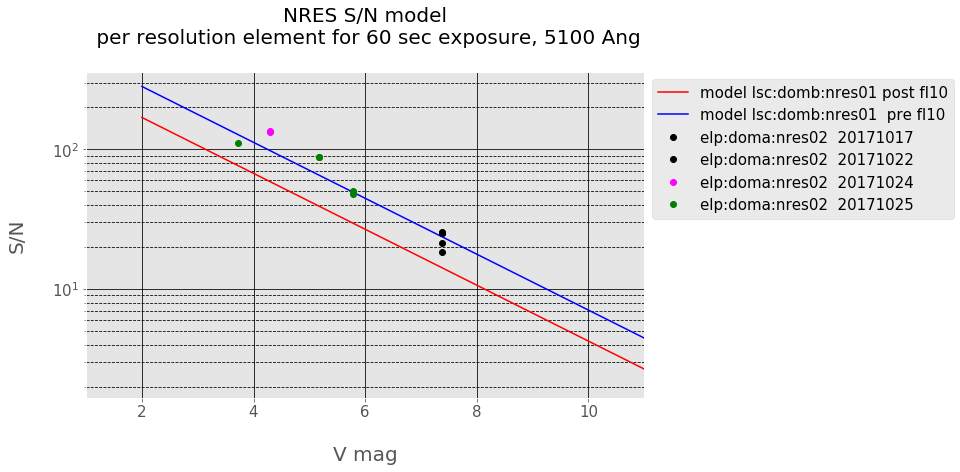

In [29]:

ron=5

fig, ax = plt.subplots(1)

plotfile (None, color='red', label='lsc:domb:nres01 post fl10', refflux=180000, ron=0)
plotfile (None , color='blue', label='lsc:domb:nres01  pre fl10', refflux=500000, ron=0)

plotfile ('nres02-20171017.txt', color='black',  label='elp:doma:nres02  20171017', refflux=0, ron=ron)
plotfile ('nres02-20171022.txt', color='black',  label='elp:doma:nres02  20171022', refflux=0, ron=ron)

plotfile ('nres02-20171024.txt', color='magenta',  label='elp:doma:nres02  20171024', refflux=0, ron=ron)
plotfile ('nres02-20171025.txt', color='green',  label='elp:doma:nres02  20171025', refflux=0, ron=ron)

# plotfile ('nres01-20171018.txt', color='magenta',  label='lsc:domb:nres01  20171018', refflux=0, ron=ron)
# plotfile ('nres01-20171019.txt', color='magenta',  label='lsc:domb:nres01  20171019', refflux=0, ron=ron)
# plotfile ('nres01-20171020.txt', color='magenta',  label='lsc:domb:nres01  20171020', refflux=0, ron=ron)
# plotfile ('nres01-20171021.txt', color='magenta', label='lsc:domb:nres01  20171021', refflux=0, ron=ron)
# plotfile ('nres01-20171022.txt', color='magenta', label='lsc:domb:nres01  20171022', refflux=0, ron=ron)
# plotfile ('nres01-20171023.txt', color='yellow', label='lsc:domb:nres01  20171023', refflux=0, ron=ron)

lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.xlim([1,11])
plt.xlabel ( "\nV mag",  fontsize=20)
plt.ylabel ("S/N\n",  fontsize=20)
plt.title ("NRES S/N model\n per resolution element for 60 sec exposure, 5100 Ang\n",  fontsize=20)

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='k', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.subplots_adjust(top=0.88)
plt.savefig("nres02sn.png", box_extra_artists=(lgd,), bbox_inches="tight");  